In [1]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

/albedo/home/pscholz/tripyview/tripyview/sub_data.py:8: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


/albedo/home/pscholz/tripyview


In [2]:
# from dask.distributed import Client
# from dask.diagnostics import ProgressBar
# import dask

# n_workers=36
# tot_mem  = 100 # GB
# print(' --> memory_limit: {:3.3f} GB'.format(tot_mem/(n_workers+1)))
# dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
# client = Client(n_workers=n_workers, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(tot_mem/n_workers))
# client

In [3]:
# Parameters
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_117/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_norim/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/help_macaspel_rglobi_117test/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/help_pengyang_cavity_core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle
which_mode= 'hslice'

vname     = ''
year      = [1979, 2019]
mon, day, record, box, depth = None, None, None, None, 1000

bw = 10
bc = [ -5.6, 35.95]
box = [bc[0]-bw/2, bc[0]+bw/2, bc[1]-bw/2, bc[1]+bw/2]
#_____________________________________________________________________________________
cstr, cnum = 'blue2red', 20
cref, crange, cmin, cmax, cfac, climit = None, None, None, None, None, None
chist, ctresh = True, 0.995

#_____________________________________________________________________________________
ncol              = 2      # number of pannel columns in figure
proj, box         = 'pc', [-180, 180, -90, 90]
do_plt            = 'tpc'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = False   # background contour line (thin)
plt_contf         = False  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh, mesh_opt = False, dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
# do_reffig         = False   # plot reference fig when doing anomalies 
# do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']

In [4]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=False)

#______________________________________________________________________________________________________
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)


 > load mesh from *.out files: /albedo/work/user/pscholz/mesh_fesom2.0/dart_test
 > comp e_area
 > comp n_area
 > compute lsmask
 > save *.shp to /albedo/work/user/pscholz/mesh_fesom2.0/dart_test/tripyview_fesom2_dart_test_pbnd.shp
 > augment lsmask


/albedo/home/pscholz/.conda/envs/newpy39/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


 > save *.shp to /albedo/work/user/pscholz/mesh_fesom2.0/dart_test/tripyview_fesom2_dart_test_focus=0.shp
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/dart_test
 > id              = dart_test
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 3160340
 > #elem           = 6262485
 > #lvls           = 70
___________________________________________


/albedo/home/pscholz/.conda/envs/newpy39/lib/python3.9/site-packages/pyogrio/geopandas.py:662: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


## <ins> Load/Plot cavity elemental vertical boundary index <ins>
In the model corresponds to the variable ulevels(elem)    
- load cavity boundary index on elements before the constrains (elemental ocean prisms are not allowed to have three boundary nodes, <br>
  there must be always at least three valid ocean layers, no isolated nodes are allowed in the vertical) are imposed e_ic_raw (cavity_elvls_raw.out)
- load cavity boundary index on elements after the constrains are imposed e_ic (cavity_elvls.out)    

In [6]:
# load partitioning 
diagpath = '/albedo/work/user/pscholz/results/dart_linfs_pc0_ctrl_1/1/'
fname    = 'fesom.mesh.diag.nc'
data     = xr.open_mfdataset(os.path.join(diagpath, fname), parallel=True)
vname_drop = list(data.keys())
# vname_drop.remove('nod_part')
vname_drop.remove('elem_part')
data = data.drop_vars(vname_drop).isel(nz=0).drop_vars(['nz','nz1']).load()
sname  = list(data.keys())[0]
print(data)
print(data[sname].data.max())

<xarray.Dataset> Size: 25MB
Dimensions:    (elem: 6262485)
Dimensions without coordinates: elem
Data variables:
    elem_part  (elem) int32 25MB 871 871 871 871 871 870 ... 870 870 870 870 870
6143


{'cstr': 'matplotlib.flag', 'cnum': np.int32(6141), 'chist': False, 'ctresh': 0.995, 'crange': [1, np.int32(6142), np.int16(3071)], 'cnlab': 8, 'cmin': 1, 'cmax': np.int32(6142), 'cref': np.int16(3071), 'cmap': <matplotlib.colors.ListedColormap object at 0x7f081a69d970>, 'clevel': array([1.000e+00, 2.000e+00, 3.000e+00, ..., 6.140e+03, 6.141e+03,
       6.142e+03]), 'clab': array([ 767., 1535., 2303., 3071., 3839., 4607., 5375.])}


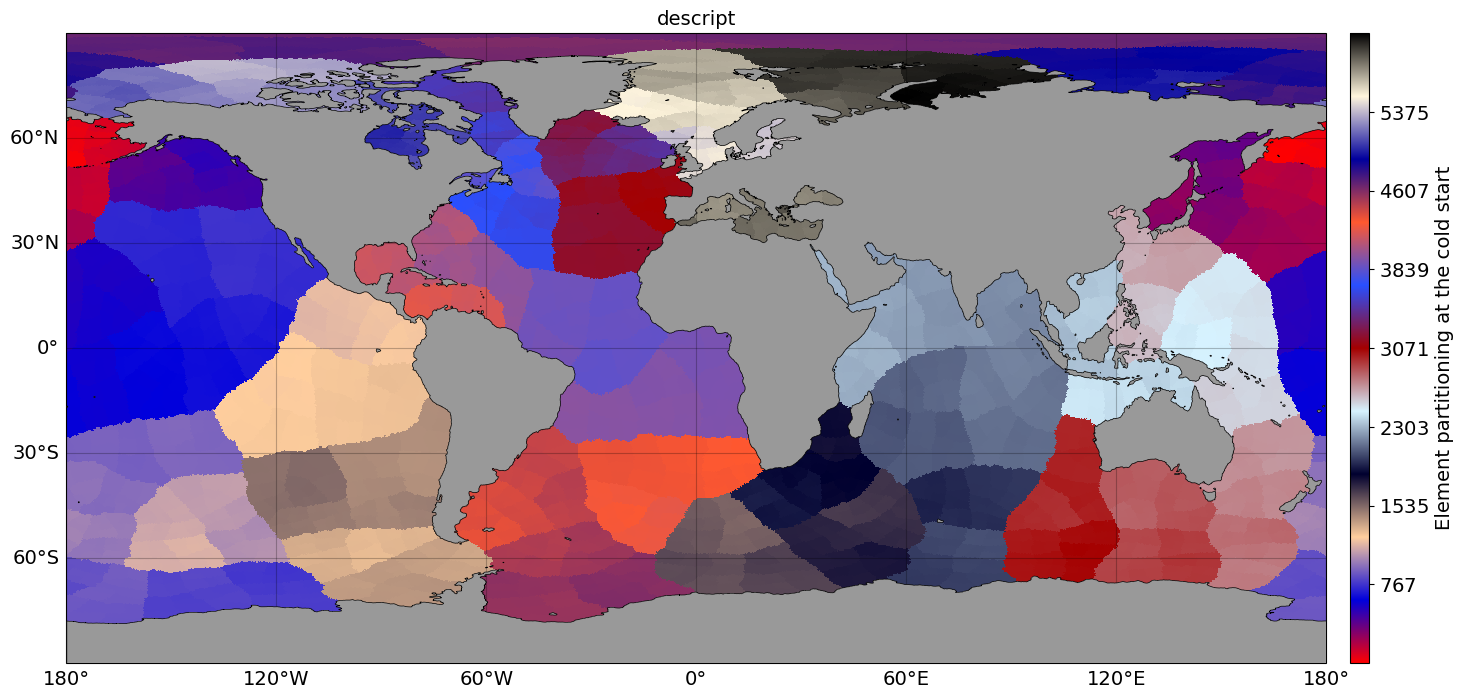

In [8]:
#___PLOT FESOM2 DATA___________________________________________________________________________________
spath  = save_path
svname = list(data.data_vars)[0]

#______________________________________________________________________________________________________
# do save filename path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}.{:s}'.format(svname, proj, sfmt)) )

#______________________________________________________________________________________________________
cinfo0 = cinfo.copy()
cinfo0.update({'cstr':'matplotlib.flag', 'crange':[1, data[sname].data.max()-1, np.int16(data[sname].data.max()/2)], 
              'chist':False, 'cnum': data[sname].data.max()-2})
fig, ax, cbar = tpv.plot_hslice(mesh, [data], cinfo=cinfo0, box=box, nrow=1, ncol=1, proj=proj, do_rescale=do_rescale,  
                                do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                ax_opt=dict({'fig_sizefac':4.0, 'cb_plt':True, 'cb_plt_single':True, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                do_save=sfpath, save_dpi=save_dpi) 
